## Naive forcast

In [3]:
import pandas as pd 

df = pd.read_csv("../data/processed/temp_clean.csv")
df

,Unnamed: 0,temp,temp_cleaned,Temp_interpolated
0,1981-01-01,20.7,20.7,20.7
1,1981-01-02,17.9,17.9,17.9
2,1981-01-03,18.8,18.8,18.8
3,1981-01-04,14.6,14.6,14.6
4,1981-01-05,15.8,15.8,15.8
...,...,...,...,...
3647,1990-12-27,14.0,14.0,14.0
3648,1990-12-28,13.6,13.6,13.6
3649,1990-12-29,13.5,13.5,13.5
3650,1990-12-30,15.7,15.7,15.7


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 80% train, 20% test
train_size = int(len(df) * 0.8)
train = df['Temp_interpolated'][:train_size]
test = df['Temp_interpolated'][train_size:]

# Afficher les tailles pour vérification
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 2921, Test size: 731


In [5]:
# Shift d’un jour pour la prédiction
y_test_naive = test[1:]
y_pred_naive = test.shift(1).iloc[1:]

mae_naive = mean_absolute_error(y_test_naive, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test_naive, y_pred_naive))

print(f"Naive Forecast -> MAE: {mae_naive:.3f}, RMSE: {rmse_naive:.3f}")



Naive Forecast -> MAE: 1.953, RMSE: 2.481


# moving avearge 


In [6]:
window = 7
y_pred_ma7 = test.rolling(window=window).mean().shift(1).iloc[window:]
y_test_ma7 = test[window:]

mae_ma7 = mean_absolute_error(y_test_ma7, y_pred_ma7)
rmse_ma7 = np.sqrt(mean_squared_error(y_test_ma7, y_pred_ma7))

print(f"Moving Average (7d) -> MAE: {mae_ma7:.3f}, RMSE: {rmse_ma7:.3f}")


Moving Average (7d) -> MAE: 2.030, RMSE: 2.583


In [7]:
window = 30
y_pred_ma30 = test.rolling(window=window).mean().shift(1).iloc[window:]
y_test_ma30 = test[window:]

mae_ma30 = mean_absolute_error(y_test_ma30, y_pred_ma30)
rmse_ma30 = np.sqrt(mean_squared_error(y_test_ma30, y_pred_ma30))

print(f"Moving Average (30d) -> MAE: {mae_ma30:.3f}, RMSE: {rmse_ma30:.3f}")



Moving Average (30d) -> MAE: 2.057, RMSE: 2.682


In [8]:

results = pd.DataFrame({
    "Model": ["Naive", "Moving Avg (7d)", "Moving Avg (30d)"],
    "MAE": [mae_naive, mae_ma7, mae_ma30],
    "RMSE": [rmse_naive, rmse_ma7, rmse_ma30]
})

print(results)


              Model       MAE      RMSE
0             Naive  1.952603  2.480897
1   Moving Avg (7d)  2.029854  2.582679
2  Moving Avg (30d)  2.056981  2.681700


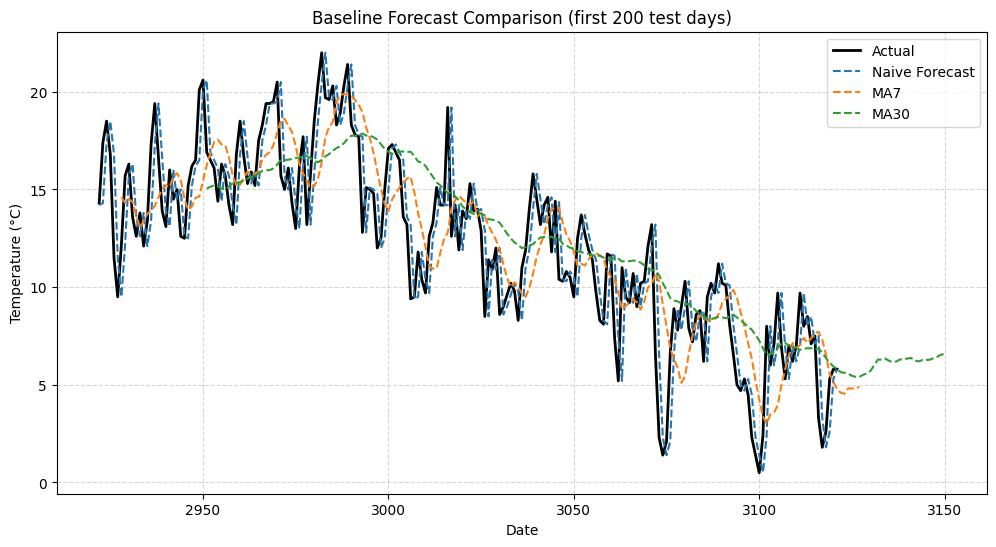

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_naive.index[:200], y_test_naive[:200], label="Actual", color="black", linewidth=2)
plt.plot(y_pred_naive.index[:200], y_pred_naive[:200], label="Naive Forecast", linestyle='--')
plt.plot(y_test_ma7.index[:200], y_pred_ma7[:200], label="MA7", linestyle='--')
plt.plot(y_test_ma30.index[:200], y_pred_ma30[:200], label="MA30", linestyle='--')

plt.title("Baseline Forecast Comparison (first 200 test days)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()





####  Interpretation
- The **Naïve model performs surprisingly well**, slightly better than both moving averages.  
- This suggests that Melbourne daily minimum temperatures have **strong short-term persistence** (today’s temperature is often close to tomorrow’s).  
- **Moving Average models smooth the noise** but introduce a **lag**, which decreases accuracy for short-term forecasts.  
- Overall, these results highlight the **challenge of beating a simple persistence baseline** in time series forecasting.

---

####  Next Steps
- Test more advanced statistical baselines (ARIMA, Exponential Smoothing) to capture seasonality.  
- Later, implement Deep Learning models (LSTM, GRU, Transformers) and compare them against these baselines.  


# advanced baseline :ARIMA 

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# ARIMA(5,1,0)
arima_order = (5,1,0)
model_arima = ARIMA(train, order=arima_order)
model_fit = model_arima.fit()

# Forecast pour toute la période test
pred_arima = model_fit.forecast(steps=len(test))

# Calcul des métriques
mae_arima = mean_absolute_error(test, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test, pred_arima))

print(f"ARIMA{arima_order} -> MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}")


ARIMA(5, 1, 0) -> MAE: 3.758, RMSE: 4.597


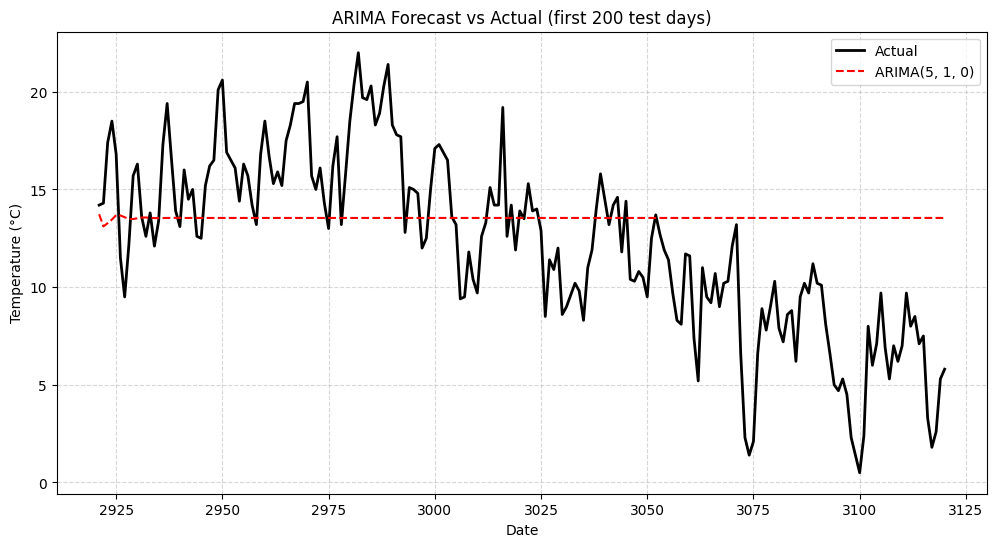

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test.index[:200], test[:200], label='Actual', color='black', linewidth=2)
plt.plot(test.index[:200], pred_arima[:200], label=f'ARIMA{arima_order}', linestyle='--', color='red')
plt.title("ARIMA Forecast vs Actual (first 200 test days)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# SARIMA: (p,d,q) x (P,D,Q,s)
sarima_model = SARIMAX(
    train,
    order=(1,1,1),               # ARIMA part
    seasonal_order=(1,1,1,365),  # saisonnalité annuelle
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)
pred_sarima = sarima_fit.forecast(steps=len(test))

# Metrics
mae_sarima = mean_absolute_error(test, pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, pred_sarima))

print(f"SARIMA -> MAE: {mae_sarima:.3f}, RMSE: {rmse_sarima:.3f}")

